In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCHDYNAMO_VERBOSE'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

import numpy as np
import random
import math
from pathlib import Path
from fastai.vision import *
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichModelSummary
from torchmetrics.text import CharErrorRate

import cv2
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt
import logging
from logging.config import fileConfig
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import json

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
fileConfig("logging.ini")
logger = logging.getLogger("trainer")
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
# logger.setLevel(logging.DEBUG)

In [2]:
# Crop images from the via json
def expand_bbox(bbox, scale=1.0):
    x1, y1, x2, y2 = bbox
    x1 = x1 - (x2 - x1) * (scale - 1) / 2
    x2 = x2 + (x2 - x1) * (scale - 1) / 2
    y1 = y1 - (y2 - y1) * (scale - 1) / 2
    y2 = y2 + (y2 - y1) * (scale - 1) / 2

    return x1, y1, x2, y2

def crop_images_from_via_json(via_json, image_dir, output_dir):

    image_dir = Path(image_dir)
    output_dir = Path(output_dir)
    
    for image_name, image_info in enumerate(via_json.values(), start=1):
        filename = image_info['filename']
        filename = filename.split('/')[-1]
        
        image_path = image_dir / filename
        # image = cv2.imread(image_path)

        for region in image_info['regions']:
            region_attributes = region['region_attributes']
            
            if 'reading' in region_attributes:
                reading = region_attributes['reading']

                if region_attributes["identity"] != "odometer":
                    continue
                if reading == "":
                    continue
            
                all_points_x = region['shape_attributes']['all_points_x']
                all_points_y = region['shape_attributes']['all_points_y']

                x1, x2 = min(all_points_x), max(all_points_x)
                y1, y2 = min(all_points_y), max(all_points_y)

                bbox = (x1, y1, x2, y2)
                x1, y1, x2, y2 = expand_bbox(bbox, scale=1.4)


                output_path = output_dir / image_dir.name
                output_path.mkdir(parents=True, exist_ok=True)

                image_output_path = output_path / f"{image_path.stem}.jpg"
                reading_output_path = output_path / f"{image_path.stem}.txt"

                if not image_output_path.exists():
                    image = Image.open(image_path)
                    cropped_image = image.crop((x1, y1, x2, y2))
                    cropped_image.save(image_output_path)
                
                if not reading_output_path.exists():
                    with open(reading_output_path, 'w') as f:
                        f.write(reading)


ROOT_DIR = Path("dataset/")
TRAIN_DIR = ROOT_DIR / "train"
TEST_DIR = ROOT_DIR / "test"

SAVE_TRAIN_DIR = ROOT_DIR / "odometer_expanded" / "train"
SAVE_TEST_DIR = ROOT_DIR / "odometer_expanded" / "test"

SAVE_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
SAVE_TEST_DIR.mkdir(parents=True, exist_ok=True)

for dir in TRAIN_DIR.iterdir():
    via_json_path = dir / "via_region_data.json"
    if via_json_path.exists():
        with open(via_json_path) as f:
            via_json = json.load(f)
    else:
        raise Exception("via json not found {}".format(via_json_path))
    
    crop_images_from_via_json(via_json, dir, SAVE_TRAIN_DIR)

for dir in TEST_DIR.iterdir():
    via_json_path = dir / "via_region_data.json"
    if via_json_path.exists():
        with open(via_json_path) as f:
            via_json = json.load(f)
    else:
        raise Exception("via json not found {}".format(via_json_path))
    
    crop_images_from_via_json(via_json, dir, SAVE_TEST_DIR)

In [3]:
ROOT_DIR = Path("dataset/odometer_expanded/")
TRAIN_DIR = ROOT_DIR / "train"
TEST_DIR = ROOT_DIR / "val"

# HF_MODEL_NAME = "microsoft/trocr-large-stage1"
# HF_MODEL_NAME = "microsoft/trocr-large-printed"
# HF_MODEL_NAME = "microsoft/trocr-large-handwritten"
# HF_MODEL_NAME = "microsoft/trocr-small-printed"
HF_MODEL_NAME = "microsoft/trocr-base-printed"


processor = TrOCRProcessor.from_pretrained(HF_MODEL_NAME)
# tokenizer = processor.tokenizer



class OdometerDataset(Dataset):
    def __init__(self, root_dir, max_length=10, transforms=None, processor: TrOCRProcessor = None):
        self.root_dir = root_dir
        self.max_length = max_length
        self.transforms = transforms
        self.processor = processor
        # self.processor = TrOCRProcessor.from_pretrained(hf_model_name)
        self.image_paths = list(sorted(self.root_dir.glob("**/*.jpg")))
        self.text_paths = list(sorted(self.root_dir.glob("**/*.txt")))

    

    def __len__(self):
        return len(self.image_paths)
    
    def filter_text(self, text):
        # Returns only the digits
        return "".join(filter(str.isdigit, text))
    
    def collate_fn(self, batch):
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        return {
            "pixel_values": pixel_values,
            "labels": labels,
        }
    
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_path = image_path.parent / (image_path.stem + ".txt")

        image = Image.open(image_path)
        
        with open(text_path) as f:
            text = f.read()
            text = self.filter_text(text)

        if self.transforms:
            image = self.transforms(image=np.array(image))["image"]
            image = processor(image, return_tensors="pt").pixel_values.squeeze(0)
        else:
            image = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        labels = self.processor.tokenizer(text, return_tensors="pt", padding="max_length", max_length=10).input_ids.squeeze(0)
        labels = [label if label != -100 else self.processor.tokenizer.pad_token_id for label in labels]
        labels = torch.tensor(labels)

        # logger.debug(f"Image: {image.shape}, Labels: {labels.shape}")
        
        return {
            "pixel_values": image,
            "labels": labels,
        }
    

        
        

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
MAX_EPOCHS = 100
MIN_EPOCHS = 10
BATCH_SIZE = 16
LOG_DIR = "tb_logs"

NUM_WORKERS = 8

MAX_LENGTH = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATES = {
    "encoder": 1e-3,
    "encoder.encoder.pooler": 1e-3,
    "decoder": 1e-3,
    "output_projection": 1e-3
}
WEIGHT_DECAY = 1e-5
MODEL_PRECISION = "bf16-mixed"

transforms = A.Compose([
    # A.LongestMaxSize(max_size=384, p=1.0),
    # A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    A.OneOf([
        # A.Compose([
            # A.Rotate(p=0.2, limit=10),
            A.RandomBrightnessContrast(p=0.2, brightness_limit=0.1, contrast_limit=0.1),
            # A.Equalize(p=1),
            A.HueSaturationValue(p=0.2, hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5),
            A.RGBShift(p=0.2, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10)),
            # A.Sharpen(p=0.2, alpha=(0.01, 0.1), lightness=(0.01, 0.1)),
    ]),
        # A.Compose([
            A.GaussNoise(p=0.2, var_limit=(10.0, 30.0)),
            # A.Affine(p=0.2, shear=10, rotate=10, scale=0.9, translate_percent=0.1),
            # A.GaussianBlur(p=0.2),
            # A.CLAHE(p=0.2, clip_limit=2, tile_grid_size=(4, 4)),
        # ]),
        # A.Compose([
            # A.MotionBlur(p=0.2, blur_limit=5, allow_shifted=True),
            # A.MedianBlur(p=0.2, blur_limit=5),
            # A.GlassBlur(p=0.2, ),
            A.ISONoise(p=0.2, intensity=(0.1, 0.2), color_shift=(0.01, 0.03)),
            # A.Downscale(p=0.2, scale_min=0.95, scale_max=0.95),
        # ]),
        # A.Compose([
        #     A.GridDistortion(p=0.2),
        #     A.OpticalDistortion(p=0.2),
        #     A.ElasticTransform(p=0.2),
        #     A.PiecewiseAffine(p=0.2),
        # ]),
        # A.Compose([
            A.JpegCompression(p=0.2),
        # ])
    # ], p=1.0),
    A.Resize(384, 384),
    # A.Normalize(),
    # ToTensorV2(),
])

transform_test = A.Compose([
    # A.LongestMaxSize(max_size=384, p=1.0),
    # A.PadIfNeeded(min_height=384, min_width=384, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    A.Resize(384, 384),
    # A.Normalize(),
    # ToTensorV2(),

])

train_dataset = OdometerDataset(TRAIN_DIR, max_length=MAX_LENGTH, transforms=transforms, processor=processor)
test_dataset = OdometerDataset(TEST_DIR, max_length=MAX_LENGTH, processor=processor, transforms=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=train_dataset.collate_fn, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=test_dataset.collate_fn, drop_last=False)


STEPS_PER_EPOCH = len(train_dataset)/BATCH_SIZE
if type(STEPS_PER_EPOCH) == float:
    STEPS_PER_EPOCH = math.ceil(STEPS_PER_EPOCH)

/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:311: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(


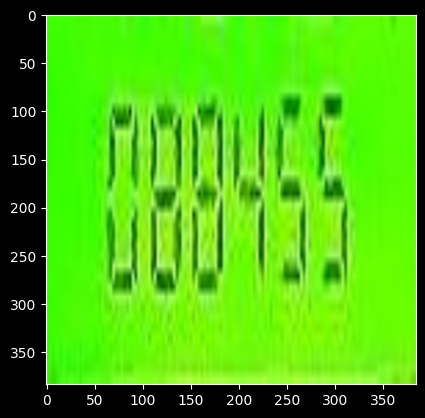

In [5]:
import random
index = random.randint(0, len(train_dataset)-1)
image = Image.open(train_dataset.image_paths[index])
image_array = np.array(image)
image_array = transforms(image=image_array)["image"]
plt.imshow(image_array)

In [6]:
model = VisionEncoderDecoderModel.from_pretrained(HF_MODEL_NAME)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = MAX_LENGTH

logger.debug("Compiling model")
optimized_model = torch.compile(model)
# optimized_model = model
optimized_model.to(DEVICE)
model.eval()
logger.debug("Model compiled")

[DEBUG]: Compiling model
[DEBUG]: Model compiled


In [7]:
# for batch in train_loader:
#     for key, value in batch.items():
#         batch[key] = value.to(DEVICE)
#     batch["pixel_values"] = batch["pixel_values"].bfloat16()
#     outputs = optimized_model(**batch)
#     pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
#     break

In [8]:
# outputs.loss, outputs.logits.shape, torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)

In [9]:
# pred_strs = processor.batch_decode(pred_ids, skip_special_tokens=True)
# og_strs = processor.batch_decode(batch["labels"], skip_special_tokens=True)

In [10]:
# plt.imshow(batch["pixel_values"][-1].float().cpu().numpy().transpose(1, 2, 0))

In [11]:
# pred_strs, og_strs

In [12]:
optimized_model, model

(OptimizedModule(
   (_orig_mod): VisionEncoderDecoderModel(
     (encoder): ViTModel(
       (embeddings): ViTEmbeddings(
         (patch_embeddings): ViTPatchEmbeddings(
           (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
         )
         (dropout): Dropout(p=0.0, inplace=False)
       )
       (encoder): ViTEncoder(
         (layer): ModuleList(
           (0-11): 12 x ViTLayer(
             (attention): ViTAttention(
               (attention): ViTSelfAttention(
                 (query): Linear(in_features=768, out_features=768, bias=False)
                 (key): Linear(in_features=768, out_features=768, bias=False)
                 (value): Linear(in_features=768, out_features=768, bias=False)
                 (dropout): Dropout(p=0.0, inplace=False)
               )
               (output): ViTSelfOutput(
                 (dense): Linear(in_features=768, out_features=768, bias=True)
                 (dropout): Dropout(p=0.0, inplace=False)
         

In [15]:
class TrOCRModelPL(L.LightningModule):
    def __init__(self, 
                 model, 
                 processor, 
                 lr=0.001, 
                 learning_rates: dict=None, 
                 batch_size=8, 
                 max_length=10, 
                 model_precision="16-true",
                 hf_model_name: str=None
                ):
        super().__init__()
        self.model = model
        self.processor = processor
        self.lr = lr
        self.cer_train = CharErrorRate()
        self.cer_val = CharErrorRate()

        self.learning_rates = learning_rates
        self.batch_size = batch_size
        self.max_length = max_length
        self.model_precision = model_precision
        self.hf_model_name = hf_model_name

        self.save_hyperparameters(
            "batch_size",
            "max_length",
            "learning_rates",
            "model_precision",
            "hf_model_name"
        )

        self.automatic_optimization = False

        self.training_step_outputs = []

    def training_step(self, batch, batch_idx):
        for key, value in batch.items():
            batch[key] = value.to(self.device)
        labels = batch["labels"].clone()

        optimizer_encoder, optimizer_encoder_pooler, optimizer_decoder, optimizer_output_projection = self.optimizers()

        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        optimizer_encoder.zero_grad()
        optimizer_encoder_pooler.zero_grad()
        optimizer_decoder.zero_grad()
        optimizer_output_projection.zero_grad()

        self.manual_backward(loss)

        optimizer_encoder.step()
        optimizer_encoder_pooler.step()
        optimizer_decoder.step()
        optimizer_output_projection.step()

        # lr_scheduler_encoder, lr_scheduler_encoder_pooler, lr_scheduler_decoder, lr_scheduler_output_projection = self.lr_schedulers()

        # lr_scheduler_encoder.step()
        # lr_scheduler_encoder_pooler.step()
        # lr_scheduler_decoder.step()
        # lr_scheduler_output_projection.step()

        pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
        pred_strs = self.processor.batch_decode(pred_ids, skip_special_tokens=True)

        labels[labels == -100] = self.processor.tokenizer.pad_token_id
        labels_strs = self.processor.batch_decode(labels, skip_special_tokens=True)

        self.cer_train(pred_strs, labels_strs)

        self.log("train_cer", self.cer_train, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        # if batch_idx % 10 == 0:
        self.logger.experiment.add_text("train_preds", str(pred_strs), self.current_epoch)
        self.logger.experiment.add_text("train_targets", str(labels_strs), self.current_epoch)

        return loss
    
    def on_train_epoch_end(self):
        
        lr_scheduler_encoder, lr_scheduler_encoder_pooler, lr_scheduler_decoder, lr_scheduler_output_projection = self.lr_schedulers()

        lr_scheduler_encoder.step()
        lr_scheduler_encoder_pooler.step()
        lr_scheduler_decoder.step()
        lr_scheduler_output_projection.step()


    
    def validation_step(self, batch, batch_idx):
        
        for key, value in batch.items():
            batch[key] = value.to(self.device)
        labels = batch["labels"].clone()

        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
        pred_strs = self.processor.batch_decode(pred_ids, skip_special_tokens=True)
        # logger.debug(f"Preds: {pred_strs}")
        labels[labels == -100] = self.processor.tokenizer.pad_token_id
        labels_strs = self.processor.batch_decode(labels, skip_special_tokens=True)
        # logger.debug(f"Targets: {labels_strs}")

        self.cer_val(pred_strs, labels_strs)

        self.log("val_cer", self.cer_val, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        # if batch_idx % 10 == 0:
        self.logger.experiment.add_text("val_preds", str(pred_strs), self.current_epoch)
        self.logger.experiment.add_text("val_targets", str(labels_strs), self.current_epoch)

        return loss
    
    def configure_optimizers(self):

        optimizer_encoder_embeddings = optim.SGD(self.model.encoder.embeddings.parameters(), lr=self.learning_rates["encoder"], momentum=0.9, weight_decay=WEIGHT_DECAY)
        optimizer_encoder = optim.SGD(self.model.encoder.encoder.parameters(), lr=self.learning_rates["encoder"], momentum=0.9, weight_decay=WEIGHT_DECAY)
        optimizer_layer_norm = optim.SGD(self.model.encoder.layernorm.parameters(), lr=self.learning_rates["encoder"], momentum=0.9, weight_decay=WEIGHT_DECAY)
        optimizer_encoder_pooler = optim.SGD(self.model.encoder.pooler.parameters(), lr=self.learning_rates["encoder.encoder.pooler"], momentum=0.9, weight_decay=WEIGHT_DECAY)
        optimizer_decoder = optim.SGD(self.model.decoder.model.parameters(), lr=self.learning_rates["decoder"], momentum=0.9, weight_decay=WEIGHT_DECAY)
        optimizer_output_projection = optim.SGD(self.model.decoder.output_projection.parameters(), lr=self.learning_rates["output_projection"], momentum=0.9, weight_decay=WEIGHT_DECAY)

        lr_scheduler_encoder_embeddings = optim.lr_scheduler.OneCycleLR(optimizer_encoder_embeddings, pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_encoder = optim.lr_scheduler.OneCycleLR(optimizer_encoder, pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_layer_norm = optim.lr_scheduler.OneCycleLR(optimizer_layer_norm, pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_encoder_pooler = optim.lr_scheduler.OneCycleLR(optimizer_encoder_pooler,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder.encoder.pooler"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_decoder = optim.lr_scheduler.OneCycleLR(optimizer_decoder,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["decoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_output_projection = optim.lr_scheduler.OneCycleLR(optimizer_output_projection,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["output_projection"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)

        # optimizer_encoder_embeddings = optim.Adam(self.model.encoder.embeddings.parameters(), lr=self.learning_rates["encoder"], eps=1e-7, weight_decay=WEIGHT_DECAY)
        # optimizer_encoder = optim.Adam(self.model.encoder.encoder.parameters(), lr=self.learning_rates["encoder"], eps=1e-7, weight_decay=WEIGHT_DECAY)
        # optimizer_layer_norm = optim.Adam(self.model.encoder.layernorm.parameters(), lr=self.learning_rates["encoder"], eps=1e-7, weight_decay=WEIGHT_DECAY)
        # optimizer_encoder_pooler = optim.Adam(self.model.encoder.pooler.parameters(), lr=self.learning_rates["encoder.encoder.pooler"], eps=1e-7, weight_decay=WEIGHT_DECAY)
        # optimizer_decoder = optim.Adam(self.model.decoder.model.parameters(), lr=self.learning_rates["decoder"], weight_decay=WEIGHT_DECAY)
        # optimizer_output_projection = optim.Adam(self.model.decoder.output_projection.parameters(), lr=self.learning_rates["output_projection"], eps=1e-7, weight_decay=WEIGHT_DECAY)

        lr_scheduler_encoder_embeddings = optim.lr_scheduler.ExponentialLR(optimizer_encoder_embeddings, gamma=0.95)
        lr_scheduler_encoder = optim.lr_scheduler.ExponentialLR(optimizer_encoder, gamma=0.95)
        lr_scheduler_layer_norm = optim.lr_scheduler.ExponentialLR(optimizer_layer_norm, gamma=0.95)
        lr_scheduler_encoder_pooler = optim.lr_scheduler.ExponentialLR(optimizer_encoder_pooler, gamma=0.95)
        lr_scheduler_decoder = optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma=0.95)
        lr_scheduler_output_projection = optim.lr_scheduler.ExponentialLR(optimizer_output_projection, gamma=0.95)
        
        lr_scheduler_encoder_embeddings = {
            "scheduler": lr_scheduler_encoder_embeddings,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_encoder_embeddings"
        }
        lr_scheduler_encoder = {
            "scheduler": lr_scheduler_encoder,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_encoder"
        }
        lr_scheduler_layer_norm = {
            "scheduler": lr_scheduler_layer_norm,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_layer_norm"
        }
        lr_scheduler_encoder_pooler = {
            "scheduler": lr_scheduler_encoder_pooler,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_encoder_pooler"
        }
        lr_scheduler_decoder = {
            "scheduler": lr_scheduler_decoder,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_decoder"
        }
        lr_scheduler_output_projection = {
            "scheduler": lr_scheduler_output_projection,
            "interval": "step",
            # "frequency": 1,
            "name": "lr_scheduler_output_projection"
        }

        return [optimizer_encoder, optimizer_encoder_pooler, optimizer_decoder, optimizer_output_projection], [lr_scheduler_encoder, lr_scheduler_encoder_pooler, lr_scheduler_decoder, lr_scheduler_output_projection]
    
    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return test_loader

In [16]:
trainer_model = TrOCRModelPL(optimized_model, 
                             processor, 
                             learning_rates=LEARNING_RATES, 
                             batch_size=BATCH_SIZE, 
                             max_length=MAX_LENGTH, 
                             model_precision=MODEL_PRECISION,
                            hf_model_name=HF_MODEL_NAME
                            )

# state_dict = torch.load("tb_logs/trocr_v2_expanded/version_1/checkpoints/odometer-epoch=51-val_loss=0.17.ckpt", map_location=DEVICE)["state_dict"]
# trainer_model.load_state_dict(state_dict)

logger.info("TrOCRModelPL created")

logger.info("Creating callbacks")
callbacks = [
    RichModelSummary(max_depth=4),
    RichProgressBar(),
    LearningRateMonitor(
        logging_interval="step",
    ),
    ModelCheckpoint(
        monitor="val_loss", 
        mode="min",
        save_top_k=3,
        filename="odometer-{epoch:02d}-{val_loss:.2f}",
        ),
    ModelCheckpoint(
        monitor="val_cer", 
        mode="min",
        save_top_k=1,
        filename="odometer-{epoch:02d}-{val_cer:.4f}-cer{val_loss:.4f}",
        ),
]

tb_logger = TensorBoardLogger(LOG_DIR, name="trocr_v2_expanded")

trainer = L.Trainer(
    accelerator="gpu",
    max_epochs=MAX_EPOCHS,
    min_epochs=MIN_EPOCHS,
    callbacks=callbacks,
    logger=tb_logger,

    precision="bf16-true",
    enable_checkpointing=True
)

logger.info("Trainer created")

[INFO]: TrOCRModelPL created
[INFO]: Creating callbacks
[INFO]: Trainer created


In [15]:
trainer.fit(trainer_model)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                                      ┃ Type                      ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ model                                     │ OptimizedModule           │  333 M │
│ 1  │ model._orig_mod                           │ VisionEncoderDecoderModel │  333 M │
│ 2  │ model._orig_mod.encoder                   │ ViTModel                  │ 86.7 M │
│ 3  │ model._orig_mod.encoder.embeddings        │ ViTEmbeddings             │  1.0 M │
│ 4  │ model._orig_mod.encoder.encoder           │ ViTEncoder                │ 85.0 M │
│ 5  │ model._orig_mod.encoder.layernorm         │ LayerNorm                 │  1.5 K │
│ 6  │ model._orig_mod.encoder.pooler            │ ViTPooler                 │  590 K │
│ 7  │ model._orig_mod.decoder                   │ TrOCRForCausalLM          │  247 M │
│ 8  │ model._orig_mod.decoder.model             │ TrOCRDecoderWrapper       │  247 M │
│ 9  │ model._orig_mod.decoder.output_projection │ Linear                    │ 51.5 M │
│ 10 │ cer_train                                 │ CharErrorRate             │      0 │
│ 11 │ cer_val                                   │ CharErrorRate             │      0 │
└────┴───────────────────────────────────────────┴───────────────────────────┴────────┘

Trainable params: 333 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 333 M                                                                                                
Total estimated model params size (MB): 1.3 K

Output()

/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 
'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,

/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 
'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,

/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 
'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,

/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 
'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,

In [17]:
state_dict = torch.load("tb_logs/trocr_v2_expanded/version_9/checkpoints/odometer-epoch=38-val_cer=0.0525-cerval_loss=0.1168.ckpt")["state_dict"]
trainer_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
model.save_pretrained("weights/trocr_base_v2/")
processor.save_pretrained("weights/trocr_base_v2/")

In [22]:

val_dataset = OdometerDataset(TEST_DIR, max_length=MAX_LENGTH, processor=processor, transforms=transform_test)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=val_dataset.collate_fn, drop_last=False)

optimized_model.eval().to(DEVICE)

for batch in val_loader:
    for key, value in batch.items():
        batch[key] = value.to(DEVICE)
        # batch[key] = value.bfloat16()
    # batch["pixel_values"] = batch["pixel_values"].bfloat16()
    outputs = optimized_model.generate(batch["pixel_values"], max_new_tokens=100)
    # outputs = optimized_model(**batch)
    # pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
    pred_ids = outputs
    break

In [23]:
pred_strs = processor.batch_decode(pred_ids, skip_special_tokens=True)
og_strs = processor.batch_decode(batch["labels"], skip_special_tokens=True)

pred_strs, og_strs

(['65400',
  '21185',
  '51498',
  '055052',
  '76295',
  '122383',
  '15018',
  '106889',
  '81144',
  '57460',
  '101132',
  '57419',
  '31110',
  '62833',
  '69111',
  '67872'],
 ['65400',
  '21185',
  '51498',
  '55052',
  '78295',
  '122383',
  '15018',
  '106889',
  '81144',
  '57460',
  '101132',
  '57419',
  '31110',
  '62833',
  '69111',
  '67872'])

In [ ]:
cer = CharErrorRate()

['66145', '111145', '533', '1906']

In [ ]:
cer(pred_strs[4], og_strs[4])

tensor(0.)

: 

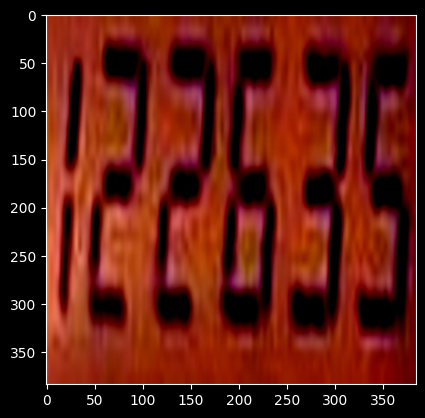

In [ ]:
plt.imshow(batch["pixel_values"][4].float().cpu().numpy().transpose(1, 2, 0))

[WARNING]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/home/vamsik1211/Data/miniconda3/envs/clearquote/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


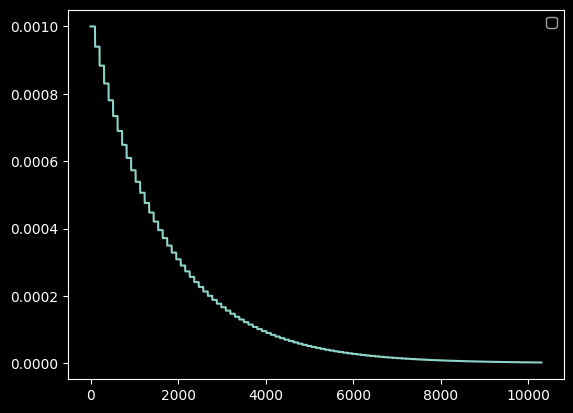

In [17]:
from matplotlib import pyplot as plt

EPOCHS = MAX_EPOCHS
BATCHES = STEPS_PER_EPOCH
steps = []
lrs = []
mtms = []
# model = ... # Your model instance
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Wrapped optimizer
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, pct_start=0.18, div_factor=1.5, final_div_factor=10000, base_momentum=0.75, max_momentum=0.95, epochs=EPOCHS, steps_per_epoch=BATCHES)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94, verbose=False)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        lrs.append(scheduler.get_last_lr()[0])
        mtms.append(optimizer.param_groups[0]['momentum'])
        steps.append(epoch * BATCHES + batch)
    scheduler.step()
    

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycleLRs')
plt.show()

In [10]:
model.parameters()

<generator object Module.parameters at 0x7f5554bdbf90>